In [1]:
import matplotlib.pyplot as plt
from t4gpd.io.CirReader import CirReader
from t4gpd.pyvista.ToUnstructuredGrid import ToUnstructuredGrid
from shapely.geometry import Polygon
from geopandas import GeoDataFrame
import numpy as np
import pandas as pd
import geopandas
from math import *
from numpy.random import randint
from shapely.geometry import LineString,Point
from t4gpd.commons.GeomLib import GeomLib
from t4gpd.demos.GeoDataFrameDemos import GeoDataFrameDemos
from t4gpd.morph.geoProcesses.FootprintExtruder import FootprintExtruder
from t4gpd.morph.geoProcesses.STGeoProcess import STGeoProcess
from t4gpd.morph.STPointsDensifier2 import STPointsDensifier2
from t4gpd.pyvista.ToUnstructuredGrid import ToUnstructuredGrid
import random

In [2]:
#gdf = GeoDataFrameDemos.districtRoyaleInNantesBuildings()
gdf = CirReader("C:/Users/zcui/Desktop/programming/Re_ Rnion bilan GLO dans le SIG/scene_masque.cir").run()

In [3]:
def module(vector):
    return np.sqrt(np.dot(np.array(vector),np.array(vector)))

In [4]:
def cmp(a,b,c=1e-10):
    return abs(a-b)<c

In [5]:
def OnSurface(self,point):
    ang = 0
    p = np.array(point)
    coord = self.exterior.coords
    for i in range(len(coord)-1):
        vec1 = np.array(coord[i]) - p
        vec2 = np.array(coord[i+1])-p
        m1 = module(vec1)
        m2 = module(vec2)
        if cmp(m1*m2,0):
            return True
        else:
            cost = np.dot(vec1,vec2)/(m1*m2)
        ang = ang +np.arccos(cost)
    return cmp(ang,2*np.pi)

In [6]:
def cosVectorAngle(vector1,vector2):#calculate the angle between two vectors
    unit_vector1 = vector1/np.linalg.norm(vector1)
    unit_vector2 = vector2/np.linalg.norm(vector2)
    dot_vector = np.dot(unit_vector1,unit_vector2)
    return dot_vector

In [7]:
def SunbeamVector(altitude_angle,azimuth_angle):#get the sunbeam vector depending on the altitude and azimuth angle
    vector_sun_x = sin(azimuth_angle)*cos(altitude_angle)
    vector_sun_y = cos(azimuth_angle)*cos(altitude_angle)
    vector_sun_z = sin(altitude_angle)
    vector_sun = np.array([vector_sun_x,vector_sun_y,vector_sun_z])
    return vector_sun

In [58]:
def SurfaceNormal(self): #input is the buildingsIn3d.geometry[i],than choose the polygon of one facet
    coord = self.exterior.coords
    facet_p0=np.array(coord[0])
    facet_p1=np.array(coord[1])
    facet_p2=np.array(coord[2])
    vec1 = facet_p1 - facet_p0
    vec2 = facet_p2 - facet_p1
    a = vec1[1]*vec2[2]-vec1[2]*vec2[1]
    b = vec1[2]*vec2[0]-vec1[0]*vec2[2]
    c = vec1[0]*vec2[1]-vec1[1]*vec2[0]
    normal = np.array([a,b,c])
    mod = module(normal)
    n  = normal/mod
    return n

In [59]:
def Sunlit(sunbeam,point,buildings):
    sun = sunbeam*100+point
    for j in range(len(buildings)):
        surface = buildings.geometry[j]
        sunline = LineString([(sun[0],sun[1]),(point1[0],point1[1])])
        p = Point(point)
        if p.intersects(surface):
            for i in range(2,len(surface)):
                n = SurfaceNormal(surface[i])
                con0 = np.dot(sunbeam,n)
                if Point(point).intersects(surface[i]):
                    if con0<0:
                        return False
                    else:
                        continue
        elif sunline.intersects(surface):
            for i in range(2,len(surface)):
                n = SurfaceNormal(surface[i])
                coords = surface[i].exterior.coords
                vec = np.array(coords[1])-point
                con1 = np.dot(sunbeam,n)
                con2 = np.dot(vec,n)
                ratio = con2/con1
                high_point = coords[2]
                if con1>0:
                    continue
                else:
                    in_point = point+ratio*sunbeam
                    if OnSurface(surface[i],Point(in_point)):
                        return False
                    else:
                        continue
        else:
            continue
    return True          

In [67]:
basemap_x=[]
basemap_y=[]
basemap_z=[]
sidewall_x=[]
sidewall_y=[]
sidewall_z=[]
for i in range(len(gdf)):
    f = gdf.geometry[i]
    fig = Polygon(f)
    x, y, z=zip(*fig.exterior.coords)

    if np.std(z)==0:
        basemap_x.append(x)
        basemap_y.append(y)
        basemap_z.append(z)
    else:
        sidewall_x.append(x)
        sidewall_y.append(y)
        sidewall_z.append(z)

In [12]:
elevation = []
for i in range(len(basemap_z)):
    elevation.append(np.mean(basemap_z[i]))
df = GeoDataFrame({'HAUTEUR':elevation},crs='epsg:2154')
df['gid'] = df.index+1

In [13]:
#lable
lable = []
for i in range(len(df)):
    if df.HAUTEUR[i]==0:
        lable.append("Ground")
    else:
        lable.append("Building")
df['Lable'] = lable

In [14]:
#geometry
geometry =[]
for i in range(len(df)):
    p = Polygon(list(zip(basemap_x[i],basemap_y[i],basemap_z[i])))
    p2 = Polygon(list(zip(basemap_x[i],basemap_y[i])))
    geometry.append(p)
df['geometry'] = geometry

_difference = df.geometry[0]#create ground with holes
for i in range(1,len(df)):
    _difference = _difference.difference(df.geometry[i])
df.at[0,'geometry']=_difference

In [15]:
#floor
floor = []
for i in range(len(df)):
    n=0
    if df.Lable[i] == 'Ground':
        floor.append(0)
    else:
        for j in range(len(sidewall_x)):
            q = Polygon(list(zip(sidewall_x[j],sidewall_y[j])))
            if df.geometry[i].contains(q):
                n = n+1
        nmb = len(basemap_x[i])-1
        floor.append(n/nmb)
df['floor'] = floor

In [16]:
from t4gpd.morph.geoProcesses.STGeoProcess import STGeoProcess
from t4gpd.morph.geoProcesses.SkyViewFactor import SkyViewFactor
from t4gpd.morph.STPointsDensifier2 import STPointsDensifier2

In [17]:
#sensors on the buildings
df2 = GeoDataFrame.copy(df)
df2.geometry = df.geometry.translate(355000,6689000)#I transfer the coordinate myself with constant value

df_buildings = GeoDataFrame.copy(df2)#Here I create a copy value of df for puting sensors
df_buildings.index -= 1
df_buildings.drop(df_buildings.index[df_buildings['Lable'] == 'Ground'], inplace = True)
sensors = STPointsDensifier2(df_buildings, curvAbsc=[0.25,0.5,0.75], pathidFieldname=None).run()
sensors.floor = sensors.floor.astype(int)

In [18]:
#create sensors in each floor level, input value 'sensors',output value 'sensors2'
from t4gpd.commons.GeomLib import GeomLib\

rows = []
for _,row in sensors.iterrows():
    for nfloor in range(row.floor):
        _row = row.copy()
        _row_z = nfloor*3.0+1.5
        _row.HAUTEUR = _row_z
        _row.floor = nfloor
        _row.geometry = GeomLib.forceZCoordinateToZ0(_row.geometry,_row_z)
        rows.append(_row)
sensors2 = GeoDataFrame(rows,crs=sensors.crs)
sensors2.reset_index(inplace=True,drop=True)

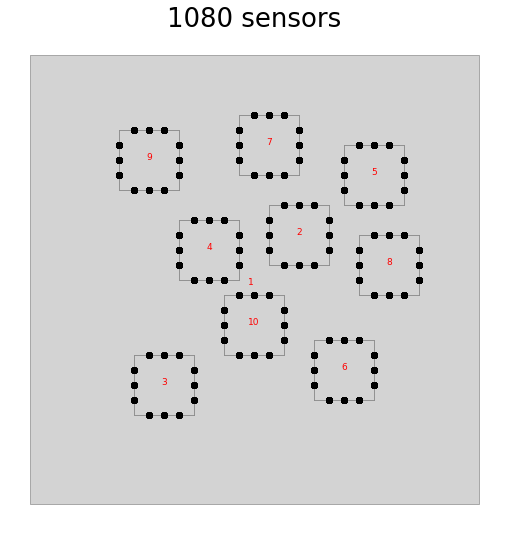

In [66]:
#plot top view(basemap with sensors)
fig, basemap = plt.subplots(figsize=(1.5 * 8.26, 1.1 * 8.26))
basemap.set_title(f'{len(sensors2)} sensors', size=26)
df2.plot(ax=basemap, color='lightgrey', edgecolor='dimgrey', linewidth=0.5)
sensors2.plot(ax=basemap, color='black')
basemap.axis('off')
df2.apply(lambda x: basemap.annotate(
			text=x.gid, xy=x.geometry.centroid.coords[0],
			#~ text=x.HAUTEUR, xy=x.geometry.centroid.coords[0],
			color='red', size=9, ha='center'), axis=1)
plt.show()

In [20]:
#direct and diffuse irradiance of each sensor(using Perez method)
from t4gpd.energy.Perez import Perez
from pysolar.solar import *
from datetime import *
from t4gpd.commons.AngleLib import AngleLib
from t4gpd.commons.DatetimeLib import DatetimeLib

In [21]:
#svf calculation
from t4gpd.morph.geoProcesses.SkyViewFactor import SkyViewFactor

op2 = SkyViewFactor(df_buildings,nRays=64,maxRayLen=100,
                  elevationFieldname= 'HAUTEUR',method=2018,background=True)
sensors2 = STGeoProcess(op2,sensors2).run()

SVF calculation method: Bernard et al. (2018), nRays = 64, maxRayLen = 100.0


In [22]:
#plot sensors and buildings
buildings = df_buildings

roads = GeoDataFrame([
    {'gid': 1, 'geometry': LineString([[-30, -10], [30, -10]])},
    {'gid': 2, 'geometry': LineString([[-30, 10], [30, 10]])},
    {'gid': 3, 'geometry': LineString([[-20, -20], [-20, 20]])},
    {'gid': 4, 'geometry': LineString([[0, -20], [0, 20]])},
    {'gid': 5, 'geometry': LineString([[20, -20], [20, 20]])}
    ])

op = FootprintExtruder(buildings, 'HAUTEUR', forceZCoordToZero=True)
buildingsIn3d = STGeoProcess(op, buildings).run()

scene1 = ToUnstructuredGrid([buildingsIn3d,sensors2], 'svf').run()

In [23]:
scene1.plot(scalars='svf', cmap='gist_earth', show_edges=False,
	show_scalar_bar=True, point_size=10.0, render_points_as_spheres=True)
#scene2.plot(scalars='floor', cmap='gist_earth', show_edges=False,
#	show_scalar_bar=True, point_size=5.0, render_points_as_spheres=True)

ViewInteractiveWidget(height=768, layout=Layout(height='auto', width='100%'), width=1024)

In [24]:
##### value sun_hits means during the period how many times sun hit shine on the sensors
d =[]
latitude = 47.16
longitude = -1.60
date = datetime(2020,6,21,8,10,tzinfo=timezone.utc)
altitude_angle = AngleLib.toRadians(get_altitude(latitude,longitude,date))
azimuth_angle = AngleLib.toRadians(get_azimuth(latitude,longitude,date))
sunbeam = SunbeamVector(altitude_angle,azimuth_angle)
for i in range(len(sensors2)):
    point1 = np.array([sensors2.geometry[i].x,sensors2.geometry[i].y,sensors2.geometry[i].z])
    ext = Sunlit(sunbeam,point1,buildingsIn3d)
    d.append(ext)
sensors2['Sunhit'] = d

In [25]:
sun_line = []
for i in range(len(sensors2)):
    if sensors2.Sunhit[i]==True:
        sun_p = sensors2.geometry[i]
        sun_p1 = Point(sun_p.x+sunbeam[0]*25,sun_p.y+sunbeam[1]*25,sun_p.z+sunbeam[2]*25)
        sun = LineString([sun_p,sun_p1])
        sun_line.append(sun)
Sunline = GeoDataFrame({'geometry':sun_line},crs='epsg:2154')

In [26]:
scene4 = ToUnstructuredGrid([buildingsIn3d,sensors2,Sunline], 'Sunhit').run()
scene4.plot(scalars='Sunhit', cmap='gist_earth', show_edges=False,
	show_scalar_bar=True, point_size=10.0, render_points_as_spheres=True)

ViewInteractiveWidget(height=768, layout=Layout(height='auto', width='100%'), width=1024)

In [68]:
#save surface normal vector
n=[]
for i in range(len(sensors2)):
    #point2 = np.array([sensors2.geometry[i].x,sensors2.geometry[i].y,sensors2.geometry[i].z])
    point2 = sensors2.geometry[i]
    for j in range(len(buildingsIn3d)):
        surface = buildingsIn3d.geometry[j]
        if point2.intersects(surface):
            for z in range(2,len(surface)):
                if point2.intersects(surface[z]):
                    normal = SurfaceNormal(surface[z])
                    n.append(normal)
sensors2['normalvector'] = n

In [28]:
from t4gpd.energy.Perez import Perez
days = date.timetuple().tm_yday
delta = 0.12 #sky's brightness (Perez et al.,1993)
epsilon = 6.3 #sky's clearness (Perez et al.,1993)
Dir = Perez.directSolarIrradiance(altitude_angle,days,delta,epsilon)
Dif = Perez.diffuseSolarIrradiance(altitude_angle,days,delta)

In [31]:
#g_ir = sensors3.direct+diffuse#global horizontal radiation
from math import*
Sho = []
for i in range(len(sensors2)):
    if sensors2.Sunhit[i]==True:
        G = Dir*abs(cosVectorAngle(sunbeam,sensors2.normalvector[i]))+Dif*sensors2.svf[i]
    else:
        G = Dif*sensors2.svf[i]
    Sho.append(G)
sensors2['SWRadiation']=Sho

In [32]:
scene5 = ToUnstructuredGrid([buildingsIn3d,sensors2], 'SWRadiation').run()
scene5.plot(scalars='SWRadiation', cmap='gist_earth', show_edges=False,
	show_scalar_bar=True, point_size=10.0, render_points_as_spheres=True)

ViewInteractiveWidget(height=768, layout=Layout(height='auto', width='100%'), width=1024)

In [33]:
def RandomDir(n):#number of samples
    vector = []
    for i in range(n):
        polar = random.random()*pi
        azimuth = random.random()*pi
        x = sin(polar)*cos(azimuth)
        y = sin(polar)*sin(azimuth)
        z = cos(polar)
        vector.append(np.array([x,y,z]))
    return vector

In [51]:
def RayPoint(point,n,norm,length):
    ray_line = []
    vec = RandomDir(n)
    for i in range(len(vec)):
        vec1 = vec[i]
        x2 = norm[0]*vec1[1]+norm[1]*vec1[0]
        y2 = norm[1]*vec1[1]-norm[0]*vec1[0]
        z2 = vec1[2]
        p2 = Point(point.x+x2*length,point.y+y2*length,point.z+z2*length)
        line = LineString([point,p2])
        ray_line.append(line)
    line_geo = GeoDataFrame({'geometry':ray_line},crs='epsg:2154')
    return line_geo

In [64]:
p_test = sensors2.geometry[500]
normal_test = sensors2.normalvector[500]
Line = RayPoint(p_test,1000,normal_test,5)
print(Line)

                                              geometry
0    LINESTRING Z (355070.000 6689005.000 19.500, 3...
1    LINESTRING Z (355070.000 6689005.000 19.500, 3...
2    LINESTRING Z (355070.000 6689005.000 19.500, 3...
3    LINESTRING Z (355070.000 6689005.000 19.500, 3...
4    LINESTRING Z (355070.000 6689005.000 19.500, 3...
..                                                 ...
995  LINESTRING Z (355070.000 6689005.000 19.500, 3...
996  LINESTRING Z (355070.000 6689005.000 19.500, 3...
997  LINESTRING Z (355070.000 6689005.000 19.500, 3...
998  LINESTRING Z (355070.000 6689005.000 19.500, 3...
999  LINESTRING Z (355070.000 6689005.000 19.500, 3...

[1000 rows x 1 columns]


In [65]:
scene6 = ToUnstructuredGrid([buildingsIn3d,sensors2,Line]).run()
scene6.plot()

ViewInteractiveWidget(height=768, layout=Layout(height='auto', width='100%'), width=1024)